In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


In [2]:
# Dataset Path
dataset_path = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2'

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'val')

# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


In [3]:
# Load Dataset
test_dir = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2/val'
train_dir = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2/train'
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Handle Class Imbalance
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset]

sampler = WeightedRandomSampler(weights=sample_weights, 
                                num_samples=len(sample_weights), 
                                replacement=True)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("✅ Classes:", train_dataset.classes)


✅ Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


In [4]:
# Attention Mechanism
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # (B, N, C')
        key = self.key(x).view(batch_size, -1, width * height)  # (B, C', N)
        energy = torch.bmm(query, key)  # (B, N, N)
        attention = torch.softmax(energy, dim=-1)  # (B, N, N)
        value = self.value(x).view(batch_size, -1, width * height)  # (B, C, N)
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, N)
        out = out.view(batch_size, C, width, height)  # (B, C, W, H)
        out = self.gamma * out + x  # Residual connection
        return out

# DermaVision-X Model
class DermaVisionX(nn.Module):
    def __init__(self, num_classes=9):  # Updated num_classes to 9
        super(DermaVisionX, self).__init__()
        
        self.base_model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.DEFAULT)
        
        # Freeze feature extraction layers
        for param in self.base_model.features.parameters():
            param.requires_grad = False
        
        # Attention Block
        self.attention = AttentionBlock(1536)  # ConvNeXt-Large outputs 1536 channels
        
        # Global Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.base_model.features(x)  # (B, 1536, 7, 7)
        x = self.attention(x)
        x = self.global_avg_pool(x).flatten(1)  # (B, 1536)
        x = self.fc(x)  # (B, num_classes)
        return x


In [5]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)

num_classes = 9  # Updated from 23 to 9
model = DermaVisionX(num_classes=num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-4)  # Optimizing only the classifier


✅ Using Device: cuda


Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:08<00:00, 96.1MB/s] 


In [6]:
# Training Loop
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []
time_per_epoch = []

best_val_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())

print("🚀 Starting Training...")

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation Phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    epoch_time = time.time() - start_time
    time_per_epoch.append(epoch_time)
    
    # Print Epoch Summary
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | 🕒 {epoch_time:.2f}s | "
          f"📉 Train Loss: {epoch_train_loss:.4f} | 📈 Train Acc: {epoch_train_acc:.2f}% | "
          f"📉 Val Loss: {epoch_val_loss:.4f} | 📈 Val Acc: {epoch_val_acc:.2f}% | "
          f"⚙️ LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save Best Model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model_weights = copy.deepcopy(model.state_dict())

# Load Best Model
model.load_state_dict(best_model_weights)
print(f"✅ Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting Training...


Epoch 1/50: 100%|██████████| 44/44 [00:20<00:00,  2.11it/s]


📊 Epoch [1/50] | 🕒 25.93s | 📉 Train Loss: 1.8906 | 📈 Train Acc: 34.72% | 📉 Val Loss: 1.4729 | 📈 Val Acc: 54.14% | ⚙️ LR: 0.000100


Epoch 2/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [2/50] | 🕒 23.62s | 📉 Train Loss: 1.3693 | 📈 Train Acc: 55.95% | 📉 Val Loss: 1.0840 | 📈 Val Acc: 64.09% | ⚙️ LR: 0.000100


Epoch 3/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [3/50] | 🕒 23.75s | 📉 Train Loss: 1.1355 | 📈 Train Acc: 64.85% | 📉 Val Loss: 0.9376 | 📈 Val Acc: 67.96% | ⚙️ LR: 0.000100


Epoch 4/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [4/50] | 🕒 23.58s | 📉 Train Loss: 0.9792 | 📈 Train Acc: 68.29% | 📉 Val Loss: 0.8831 | 📈 Val Acc: 68.51% | ⚙️ LR: 0.000100


Epoch 5/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [5/50] | 🕒 23.71s | 📉 Train Loss: 0.9219 | 📈 Train Acc: 71.31% | 📉 Val Loss: 0.7996 | 📈 Val Acc: 71.82% | ⚙️ LR: 0.000100


Epoch 6/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [6/50] | 🕒 23.68s | 📉 Train Loss: 0.8083 | 📈 Train Acc: 75.75% | 📉 Val Loss: 0.7318 | 📈 Val Acc: 75.69% | ⚙️ LR: 0.000100


Epoch 7/50: 100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


📊 Epoch [7/50] | 🕒 23.40s | 📉 Train Loss: 0.7613 | 📈 Train Acc: 74.89% | 📉 Val Loss: 0.6757 | 📈 Val Acc: 75.14% | ⚙️ LR: 0.000100


Epoch 8/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [8/50] | 🕒 23.68s | 📉 Train Loss: 0.7408 | 📈 Train Acc: 75.04% | 📉 Val Loss: 0.6602 | 📈 Val Acc: 76.24% | ⚙️ LR: 0.000100


Epoch 9/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [9/50] | 🕒 23.56s | 📉 Train Loss: 0.6690 | 📈 Train Acc: 78.34% | 📉 Val Loss: 0.6288 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 10/50: 100%|██████████| 44/44 [00:19<00:00,  2.27it/s]


📊 Epoch [10/50] | 🕒 23.36s | 📉 Train Loss: 0.6423 | 📈 Train Acc: 78.48% | 📉 Val Loss: 0.6014 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 11/50: 100%|██████████| 44/44 [00:19<00:00,  2.22it/s]


📊 Epoch [11/50] | 🕒 23.82s | 📉 Train Loss: 0.6266 | 📈 Train Acc: 77.33% | 📉 Val Loss: 0.5856 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 12/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [12/50] | 🕒 23.70s | 📉 Train Loss: 0.5889 | 📈 Train Acc: 80.63% | 📉 Val Loss: 0.5811 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 13/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [13/50] | 🕒 23.67s | 📉 Train Loss: 0.6375 | 📈 Train Acc: 78.91% | 📉 Val Loss: 0.5756 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 14/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [14/50] | 🕒 23.55s | 📉 Train Loss: 0.5615 | 📈 Train Acc: 81.92% | 📉 Val Loss: 0.5995 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 15/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [15/50] | 🕒 23.73s | 📉 Train Loss: 0.5620 | 📈 Train Acc: 79.91% | 📉 Val Loss: 0.6152 | 📈 Val Acc: 76.80% | ⚙️ LR: 0.000100


Epoch 16/50: 100%|██████████| 44/44 [00:19<00:00,  2.21it/s]


📊 Epoch [16/50] | 🕒 23.92s | 📉 Train Loss: 0.5703 | 📈 Train Acc: 80.20% | 📉 Val Loss: 0.5473 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 17/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [17/50] | 🕒 23.53s | 📉 Train Loss: 0.5746 | 📈 Train Acc: 78.77% | 📉 Val Loss: 0.5646 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 18/50: 100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


📊 Epoch [18/50] | 🕒 23.52s | 📉 Train Loss: 0.4786 | 📈 Train Acc: 83.36% | 📉 Val Loss: 0.5302 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 19/50: 100%|██████████| 44/44 [00:19<00:00,  2.22it/s]


📊 Epoch [19/50] | 🕒 23.82s | 📉 Train Loss: 0.5055 | 📈 Train Acc: 82.35% | 📉 Val Loss: 0.5357 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 20/50: 100%|██████████| 44/44 [00:19<00:00,  2.22it/s]


📊 Epoch [20/50] | 🕒 23.82s | 📉 Train Loss: 0.4970 | 📈 Train Acc: 81.92% | 📉 Val Loss: 0.5469 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 21/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [21/50] | 🕒 23.75s | 📉 Train Loss: 0.4637 | 📈 Train Acc: 82.93% | 📉 Val Loss: 0.5238 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 22/50: 100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


📊 Epoch [22/50] | 🕒 23.45s | 📉 Train Loss: 0.4682 | 📈 Train Acc: 83.64% | 📉 Val Loss: 0.5156 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 23/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [23/50] | 🕒 23.64s | 📉 Train Loss: 0.4504 | 📈 Train Acc: 84.22% | 📉 Val Loss: 0.5356 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 24/50: 100%|██████████| 44/44 [00:19<00:00,  2.21it/s]


📊 Epoch [24/50] | 🕒 23.92s | 📉 Train Loss: 0.3851 | 📈 Train Acc: 88.52% | 📉 Val Loss: 0.5048 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 25/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [25/50] | 🕒 23.68s | 📉 Train Loss: 0.3918 | 📈 Train Acc: 85.94% | 📉 Val Loss: 0.5535 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 26/50: 100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


📊 Epoch [26/50] | 🕒 23.45s | 📉 Train Loss: 0.4064 | 📈 Train Acc: 86.23% | 📉 Val Loss: 0.5278 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 27/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [27/50] | 🕒 23.65s | 📉 Train Loss: 0.4740 | 📈 Train Acc: 84.65% | 📉 Val Loss: 0.4922 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 28/50: 100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


📊 Epoch [28/50] | 🕒 23.44s | 📉 Train Loss: 0.4248 | 📈 Train Acc: 84.22% | 📉 Val Loss: 0.4865 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 29/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [29/50] | 🕒 23.73s | 📉 Train Loss: 0.4452 | 📈 Train Acc: 82.35% | 📉 Val Loss: 0.4679 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 30/50: 100%|██████████| 44/44 [00:19<00:00,  2.29it/s]


📊 Epoch [30/50] | 🕒 23.27s | 📉 Train Loss: 0.3632 | 📈 Train Acc: 86.23% | 📉 Val Loss: 0.4589 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 31/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [31/50] | 🕒 23.65s | 📉 Train Loss: 0.4113 | 📈 Train Acc: 83.93% | 📉 Val Loss: 0.4907 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 32/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [32/50] | 🕒 23.67s | 📉 Train Loss: 0.3623 | 📈 Train Acc: 87.95% | 📉 Val Loss: 0.4650 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 33/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [33/50] | 🕒 23.67s | 📉 Train Loss: 0.3776 | 📈 Train Acc: 85.65% | 📉 Val Loss: 0.4718 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 34/50: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


📊 Epoch [34/50] | 🕒 23.58s | 📉 Train Loss: 0.3993 | 📈 Train Acc: 85.80% | 📉 Val Loss: 0.4847 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 35/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [35/50] | 🕒 23.54s | 📉 Train Loss: 0.3876 | 📈 Train Acc: 86.08% | 📉 Val Loss: 0.4771 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 36/50: 100%|██████████| 44/44 [00:19<00:00,  2.27it/s]


📊 Epoch [36/50] | 🕒 23.36s | 📉 Train Loss: 0.3292 | 📈 Train Acc: 88.09% | 📉 Val Loss: 0.5040 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 37/50: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]


📊 Epoch [37/50] | 🕒 26.75s | 📉 Train Loss: 0.3570 | 📈 Train Acc: 87.37% | 📉 Val Loss: 0.4614 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 38/50: 100%|██████████| 44/44 [00:19<00:00,  2.27it/s]


📊 Epoch [38/50] | 🕒 23.40s | 📉 Train Loss: 0.3929 | 📈 Train Acc: 85.51% | 📉 Val Loss: 0.4978 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 39/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [39/50] | 🕒 23.48s | 📉 Train Loss: 0.3891 | 📈 Train Acc: 84.65% | 📉 Val Loss: 0.5582 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 40/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [40/50] | 🕒 23.72s | 📉 Train Loss: 0.3991 | 📈 Train Acc: 84.65% | 📉 Val Loss: 0.5289 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 41/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [41/50] | 🕒 23.75s | 📉 Train Loss: 0.3141 | 📈 Train Acc: 89.67% | 📉 Val Loss: 0.4965 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 42/50: 100%|██████████| 44/44 [00:19<00:00,  2.27it/s]


📊 Epoch [42/50] | 🕒 23.58s | 📉 Train Loss: 0.3846 | 📈 Train Acc: 86.23% | 📉 Val Loss: 0.5175 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 43/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [43/50] | 🕒 23.50s | 📉 Train Loss: 0.3485 | 📈 Train Acc: 88.52% | 📉 Val Loss: 0.5081 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 44/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [44/50] | 🕒 23.74s | 📉 Train Loss: 0.3468 | 📈 Train Acc: 87.95% | 📉 Val Loss: 0.5072 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 45/50: 100%|██████████| 44/44 [00:19<00:00,  2.21it/s]


📊 Epoch [45/50] | 🕒 23.98s | 📉 Train Loss: 0.3330 | 📈 Train Acc: 87.52% | 📉 Val Loss: 0.4723 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 46/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [46/50] | 🕒 23.82s | 📉 Train Loss: 0.3393 | 📈 Train Acc: 87.66% | 📉 Val Loss: 0.4573 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 47/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [47/50] | 🕒 23.54s | 📉 Train Loss: 0.3524 | 📈 Train Acc: 88.38% | 📉 Val Loss: 0.5274 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 48/50: 100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


📊 Epoch [48/50] | 🕒 23.50s | 📉 Train Loss: 0.3368 | 📈 Train Acc: 88.09% | 📉 Val Loss: 0.5084 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 49/50: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


📊 Epoch [49/50] | 🕒 23.67s | 📉 Train Loss: 0.3091 | 📈 Train Acc: 88.95% | 📉 Val Loss: 0.4724 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 50/50: 100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


📊 Epoch [50/50] | 🕒 23.57s | 📉 Train Loss: 0.3483 | 📈 Train Acc: 86.23% | 📉 Val Loss: 0.5096 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100
✅ Training complete. Best Validation Accuracy: 85.64%


In [7]:
# Save the Best Model
model_save_path = '/kaggle/working/DermaVisionXSkinClassifier_Best.pth'
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model Saved at {model_save_path}!")


✅ Model Saved at /kaggle/working/DermaVisionXSkinClassifier_Best.pth!


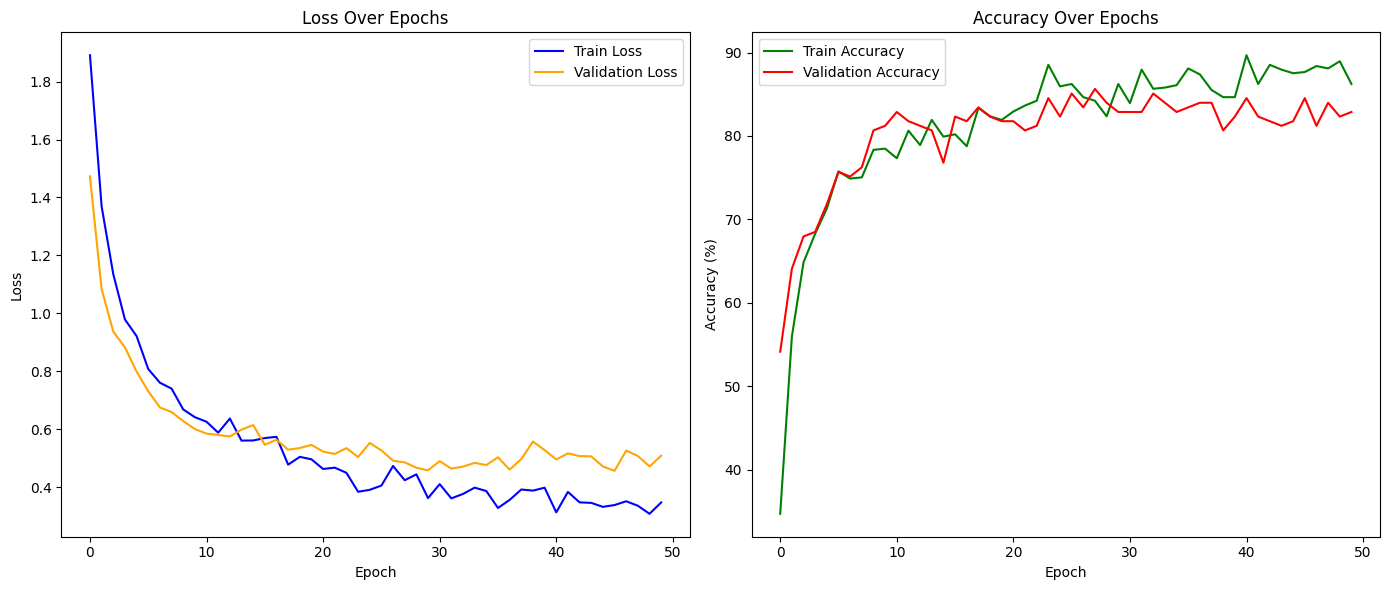

In [8]:
# Plot Metrics
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Gather Predictions and Labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


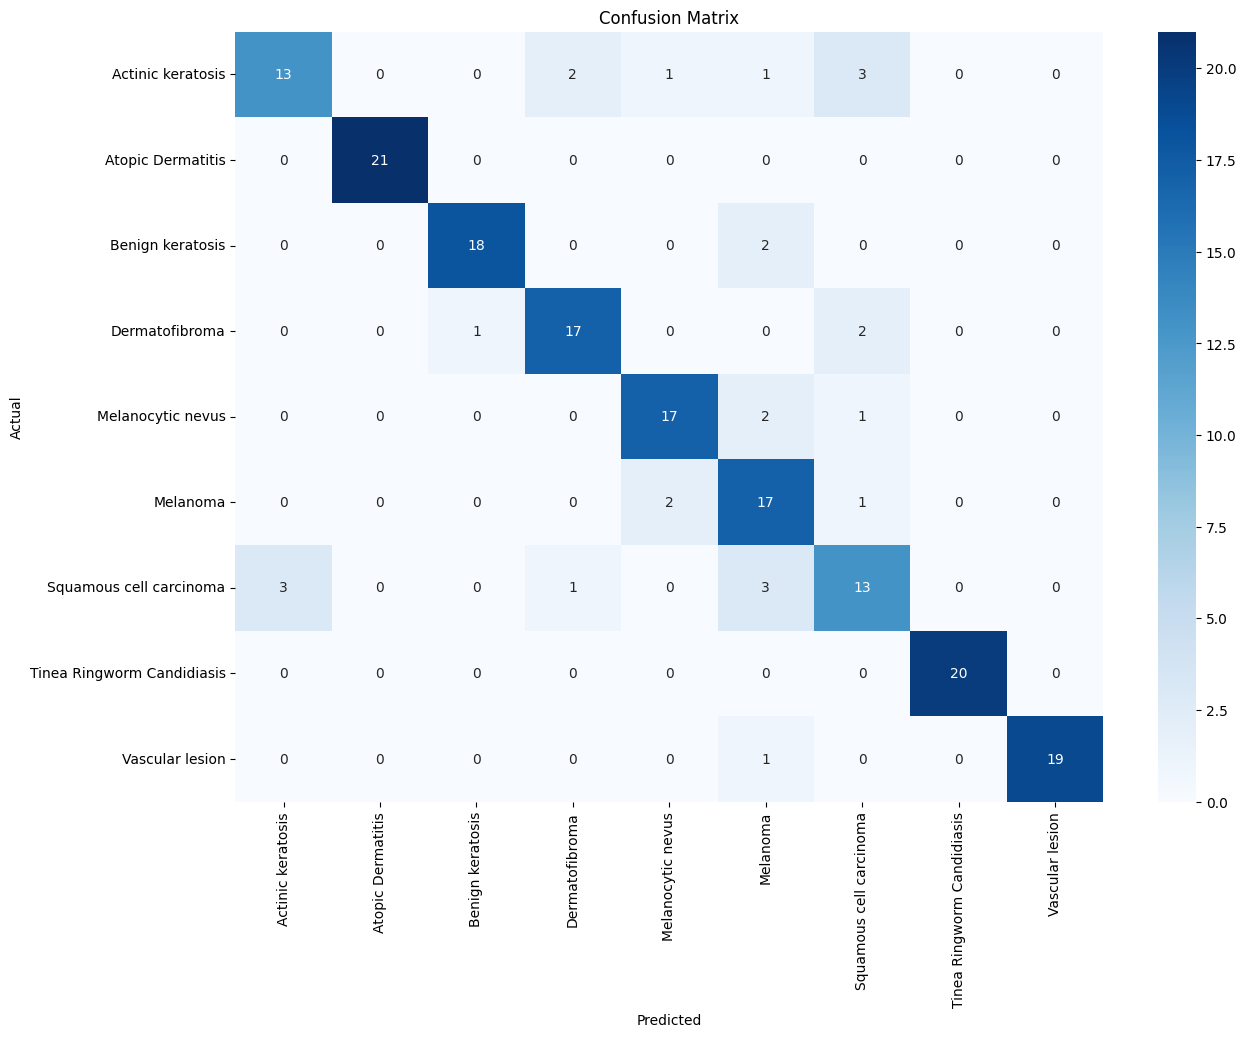


📊 Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.81      0.65      0.72        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       0.95      0.90      0.92        20
            Dermatofibroma       0.85      0.85      0.85        20
         Melanocytic nevus       0.85      0.85      0.85        20
                  Melanoma       0.65      0.85      0.74        20
   Squamous cell carcinoma       0.65      0.65      0.65        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      0.95      0.97        20

                  accuracy                           0.86       181
                 macro avg       0.86      0.86      0.86       181
              weighted avg       0.86      0.86      0.86       181



In [10]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


✅ Class Names Aligned Successfully: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


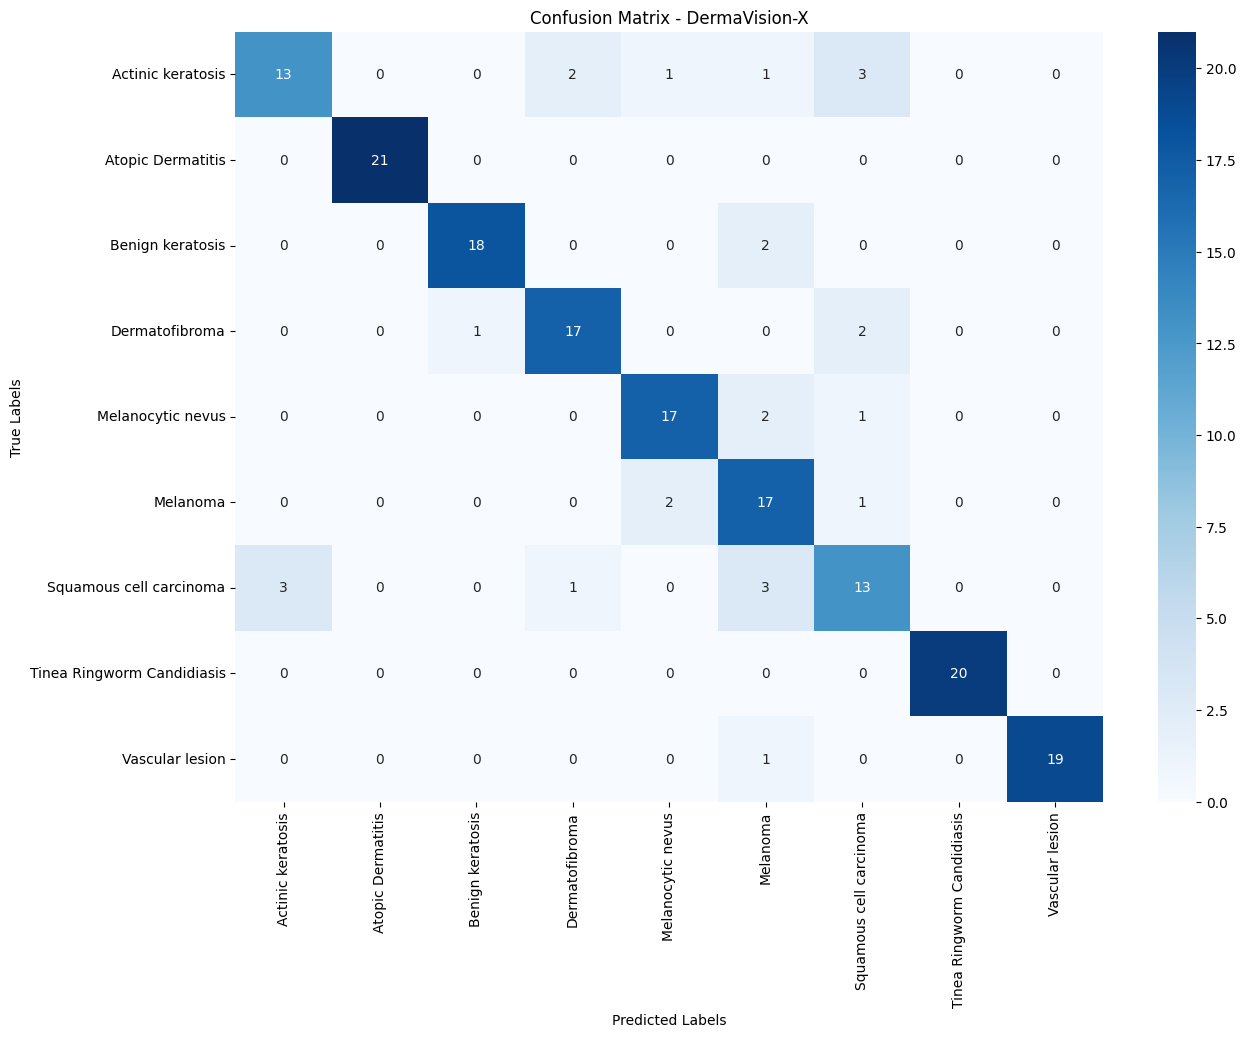

✅ Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.81      0.65      0.72        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       0.95      0.90      0.92        20
            Dermatofibroma       0.85      0.85      0.85        20
         Melanocytic nevus       0.85      0.85      0.85        20
                  Melanoma       0.65      0.85      0.74        20
   Squamous cell carcinoma       0.65      0.65      0.65        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      0.95      0.97        20

                  accuracy                           0.86       181
                 macro avg       0.86      0.86      0.86       181
              weighted avg       0.86      0.86      0.86       181


✅ Overall Metrics:
🔹 Accuracy: 0.8564
🔹 Error Rate: 0.1436
🔹 Precision (Macro Avg): 0.8

In [11]:
# Additional Metrics Calculation

# Class Names
class_names = train_dataset.classes
print("✅ Class Names Aligned Successfully:", class_names)

# Confusion Matrix for Additional Metrics
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix - DermaVision-X')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report with Zero Division Handling
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Overall Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
error_rate = 1 - accuracy

# Specificity Calculation
def calculate_specificity_per_class(cm):
    specificity_per_class = []
    num_classes = cm.shape[0]
    
    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_per_class.append(specificity)
    
    specificity_avg = np.mean(specificity_per_class)
    return specificity_avg, specificity_per_class

specificity_avg, specificity_per_class = calculate_specificity_per_class(cm)

# Print Overall Metrics
print("\n✅ Overall Metrics:")
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Error Rate: {error_rate:.4f}")
print(f"🔹 Precision (Macro Avg): {precision:.4f}")
print(f"🔹 Recall (Macro Avg): {recall:.4f}")
print(f"🔹 F1-Score (Macro Avg): {f1:.4f}")
print(f"🔹 Specificity (Macro Avg): {specificity_avg:.4f}")

# Print Class-wise Specificity
print("\n✅ Specificity per Class:")
for i, spec in enumerate(specificity_per_class):
    print(f"🔹 {class_names[i]}: {spec:.4f}")


In [12]:
# Direct Evaluation after Loading
# If you need to load the model later, use the following code:

# Initialize the DermaVisionX model
# model = DermaVisionX(num_classes=9)

# Move Model to Device
# model = model.to(device)

# Load the saved state dictionary
# model_save_path = '/kaggle/working/DermaVisionXSkinClassifier_Best.pth'
# model.load_state_dict(torch.load(model_save_path))
# model.eval()
# print(f"✅ Loaded Model from {model_save_path}!")

# # Perform evaluation as done previously
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Proceed with metrics calculation as in previous cells
